In [1]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.volume import MFIIndicator 
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator
from ta.trend import MACD, CCIIndicator
from ta.volatility import BollingerBands
import warnings
warnings.filterwarnings('ignore')
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [2]:
data = pd.read_csv('.\data1mins.csv')
data

Loading ITables v2.5.2 from the internet... (need help?)


In [3]:
data.Date = pd.to_datetime(data.Date, errors = 'coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index()

In [4]:
from scipy import signal
from scipy.signal import butter,lfilter 

def lowpass_filter_period_only(x, cutoff_period: int = 20, order: int = 2, zero_phase: bool = False):
    cutoff_period = max(int(cutoff_period), 3)  # kẹp tối thiểu 3
    Wn = 2.0 / float(cutoff_period)
    Wn = min(max(Wn, 1e-6), 0.999999)          # đảm bảo (0,1)
    sos = butter(order, Wn, btype="low", output="sos")
    if zero_phase:
        y = signal.sosfiltfilt(sos, pd.Series(x).values, method="gust")
    else:
        y = signal.sosfilt(sos, pd.Series(x).values)
    return pd.Series(y, index=pd.Series(x).index)


In [5]:
df = pd.read_csv('.\expiration_date.csv')
df.Date = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2245, 10, 16),
 datetime.date(2072, 11, 17),
 datetime.date(2080, 4, 18),
 datetime.date(2092, 12, 18),
 datetime.date(2149, 8, 21),
 datetime.date(2244, 10, 17),
 datetime.date(2094, 2, 18),
 datetime.date(2208, 3, 17),
 datetime.date(2193, 12, 19),
 datetime.date(2174, 5, 19),
 datetime.date(2034, 10, 19),
 datetime.date(2258, 3, 18),
 datetime.date(2044, 10, 20),
 datetime.date(2249, 10, 18),
 datetime.date(2103, 1, 18),
 datetime.date(2206, 8, 21),
 datetime.date(2227, 12, 20),
 datetime.date(2039, 11, 17),
 datetime.date(2150, 7, 16),
 datetime.date(2132, 3, 20),
 datetime.date(2176, 7, 18),
 datetime.date(2083, 7, 15),
 datetime.date(2067, 5, 19),
 datetime.date(2196, 11, 17),
 datetime.date(2196, 6, 16),
 datetime.date(2097, 11, 21),
 datetime.date(2082, 3, 19),
 datetime.date(2079, 3, 16),
 datetime.date(2134, 10, 21),
 datetime.date(2254, 6, 15),
 datetime.date(2117, 8, 19),
 datetime.date(2051, 2, 16),
 datetime.date(2084, 3, 16),
 datetime.date(2133, 8, 20),
 

In [6]:
import numpy as np
import pandas as pd
import datetime
from ta.volume import MFIIndicator, OnBalanceVolumeIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.trend import ADXIndicator

In [17]:
# AverageTrueRange, CCIIndicator, IchimokuIndicator, MACD, RSI, ADXIndicator, MFI, stochastic,
def alpha(data, params):
    data['Close_filtered'] = lowpass_filter_period_only(data['Close'], params['t1'])
    
    # Tính MFI 2 Line với 2 cửa sổ khác nhau
    data['MFI_fast'] = MFIIndicator(high=data['High'], low=data['Low'], close=data['Close'], 
                                   volume=data['Volume'], window=params['w1_fast']).money_flow_index()
    data['MFI_slow'] = MFIIndicator(high=data['High'], low=data['Low'], close=data['Close'], 
                                   volume=data['Volume'], window=params['w2_slow']).money_flow_index()
    
    pos = 0
    position = []
    prev_mfi_fast = None
    prev_mfi_slow = None
    
    for i in range(len(data)):
        # Lấy giá trị MFI
        mfi_fast = data['MFI_fast'].values[i]
        mfi_slow = data['MFI_slow'].values[i]
        
        # Xác định tín hiệu giao cắt
        bullish_cross = False
        bearish_cross = False
        
        if prev_mfi_fast is not None and prev_mfi_slow is not None:
            # Tín hiệu tăng: MFI Fast cắt lên trên MFI Slow
            if prev_mfi_fast <= prev_mfi_slow and mfi_fast > mfi_slow:
                bullish_cross = True
            # Tín hiệu giảm: MFI Fast cắt xuống dưới MFI Slow
            elif prev_mfi_fast >= prev_mfi_slow and mfi_fast < mfi_slow:
                bearish_cross = True
        
        # Cập nhật giá trị trước đó
        prev_mfi_fast = mfi_fast
        prev_mfi_slow = mfi_slow
        
        # Logic vào/thoát lệnh dựa trên tín hiệu giao cắt
        if pos == 0:
            # Điều kiện enter short - MFI Fast cắt xuống dưới MFI Slow
            if bearish_cross:
                pos = -1
            # Điều kiện vào long - MFI Fast cắt lên trên MFI Slow
            elif bullish_cross:
                pos = 1
        elif pos == -1:
            # Thoát short khi MFI Fast cắt lên trên MFI Slow
            if bullish_cross:
                pos = 0
        else:
            # Thoát long khi MFI Fast cắt xuống dưới MFI Slow
            if bearish_cross:
                pos = 0
                
        # Các điều kiện thoát lệnh theo thời gian
        if data['Date'].iloc[i].time() == datetime.time(14, 25):
            # Thoát short cuối ngày
            if pos == -1:
                pos = 0
                
        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0:
                # Reset vị thế ngày đáo hạn
                if data['Date'].iloc[i].date() in expiration_date:
                    pos = 0

        position.append(pos)
    
    data['pos'] = position
    return data

In [ ]:
params = {'t1': 0.75, 't2': 15, 't3': 66, 't4': 55, 't5': 53, 'w1': 21,  'w1_fast':5, 'w2_slow':14}

In [27]:
ds = alpha(data, params)
ds

Loading ITables v2.5.2 from the internet... (need help?)


Margin: 0.69
MDD: 303.3 (19.32%)

   Total trading quantity: 5121
         Profit per trade: -0.96
             Total Profit: 771.8
         Profit after fee: -4911.2
 Trading quantity per day: 2.7
 Profit per day after fee: -2.59
                   Return: -0.41
          Profit per year: -644.58
                  HitRate: 0.39
          HitRate per day: 0.48


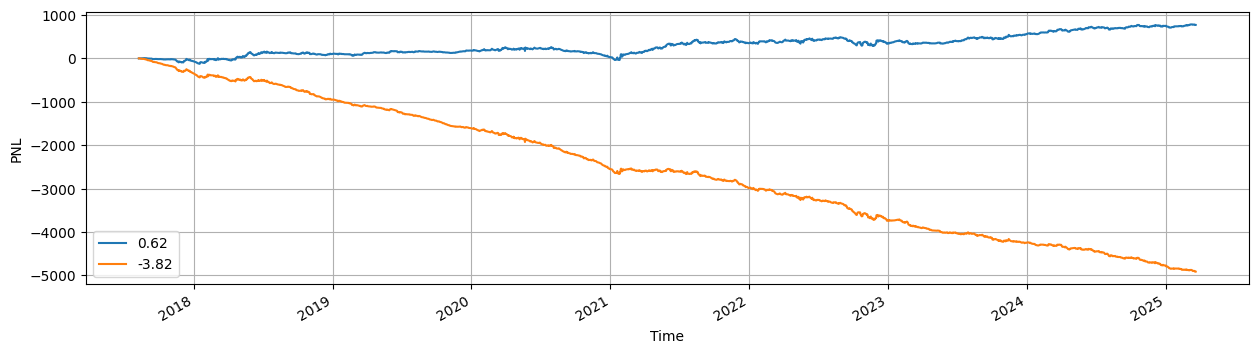

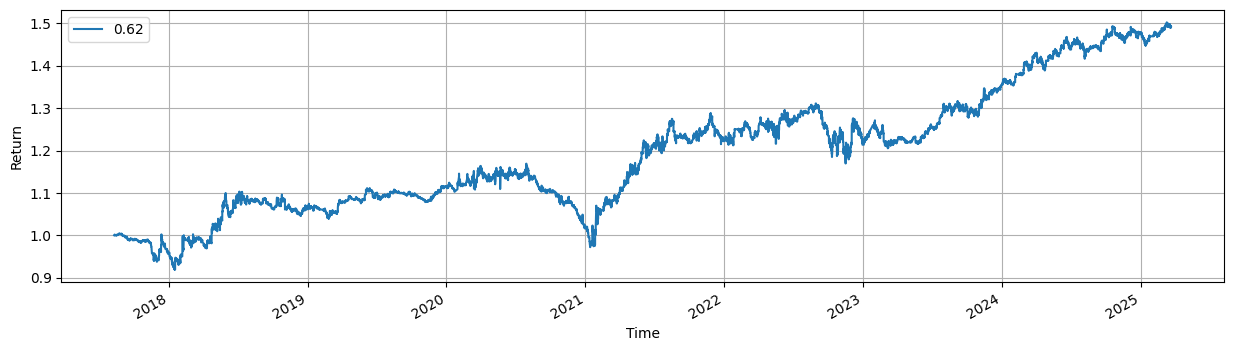

In [28]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()